# A-Feature Analysis
This is an optional notebook where we will go through the steps of creating random walks using the A-path method. These can be used as a feature when learning HAS-embeddings in the HAS_entity_embeddings notebook. We will consider different implementation decisions and look at the results of using this feature for learning embeddings.

*What is this feature?* --> These random walks are intended to detect attributive similarity. I.e. entities with similar attribute values are similar.

## Pre-requisite steps to run this notebook
1. You need to run the 1_candidate_label_creation notebook before this notebook.
2. gensim is a dependency. You can install it with `pip install --upgrade gensim`, or if you want to use Anaconda, `conda install -c conda-forge gensim`

In [3]:
import os
import math
import random
import numpy as np
import pandas as pd
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import json
from sklearn.preprocessing import MinMaxScaler
from collections import defaultdict

## parameters

**Embedding model parameters**   
*type_to_profile*: Q-node denoting the type of entities you want to create embeddings for (potentially do this for all types in the dataset and get rid of this parameter)
*num_walks*: Number of random walks to start at each node with the A-feature walk method   
*walk_length*: Length of random walk started at each node  
*representation_size*: Number of latent dimensions to learn from each node  
*window_size*: Window size of skipgram model  
*workers*: Number of parallel processes  

**File/Directory parameters**  
*label_file*: File path for the file that contains wikidata labels.  
*work_dir*: same work_dir that you specified in the label creation notebook. We'll look for files created by that notebook here. Files created by this notebook will also be saved here.  
*store_dir*: Path to folder containing the sqlite3.db file that we will use for our queries. We will reuse an existing file if there is one in this folder. Otherwise we will create a new one.

In [35]:
# Embedding model params
type_to_profile = "Q5"
num_walks = 10
walk_length = 10
representation_size = 64
window_size = 5
workers = 32

# File/Directory params
data_dir = "./data/wikidata_humans"
label_file = "{}/labels.en.tsv.gz".format(data_dir)
work_dir = "./output/wikidata_humans_v3"
store_dir = "./output/wikidata_humans_v3/temp"

### Process parameters and set up variables / file names

In [36]:
# Ensure paths are absolute
label_file = os.path.abspath(label_file)
work_dir = os.path.abspath(work_dir)
store_dir = os.path.abspath(store_dir)
    
# Create directories
if not os.path.exists(work_dir):
    os.makedirs(work_dir)
output_dir = "{}/A_walks_analysis".format(work_dir)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
if not os.path.exists(store_dir):
    os.makedirs(store_dir)
    
walks_file = "{}/a_walks.txt".format(output_dir)

# Setting up environment variables 
os.environ["TYPE"] = type_to_profile
os.environ['LABEL_FILE'] = label_file
os.environ['STORE'] = "{}/wikidata.sqlite3.db".format(store_dir)
os.environ['LABEL_CREATION'] = "{}/label_creation".format(work_dir)
os.environ['OUT'] = output_dir
os.environ['kgtk'] = "kgtk" # Need to do this for kgtk to be recognized as a command when passing it through a subprocess call

### 1. Create mapping of {entity : other entities that can be hopped to}

In [53]:
# given values that all correspond to the same label kind,
# return corresponding intervals based on percentile
def get_bin_nums_for_values_based_on_percentile(values, num_bins):
    values = np.array(values)
    indexes = np.arange(len(values))
    
    # sort values and corresponding labels in ascending order
    indexes = np.array([i for i, v in sorted(zip(indexes, values), key=lambda pair: pair[1])])
    values.sort()
    
    interval_bounds = []
    for i in range(num_bins):
        index_of_ubound = math.ceil(((i+1)/num_bins)*len(values)) - 1
        ubound = values[index_of_ubound]
        if len(interval_bounds)==0 or ubound != interval_bounds[-1]:
            interval_bounds.append(ubound)
    bin_nums_for_values=[]
    cur_bin_num=0
    for i in range(len(values)):
        while values[i] > interval_bounds[cur_bin_num]:
            cur_bin_num += 1
        bin_nums_for_values.append(cur_bin_num)
    
    # rearrange bin nums to original order of values
    bin_nums_for_values_unscrambled = np.zeros(len(bin_nums_for_values), dtype=int)
    for i in range(len(indexes)):
        bin_nums_for_values_unscrambled[indexes[i]] = bin_nums_for_values[i]
        
    return bin_nums_for_values_unscrambled
    
    
# Given a file containing numeric valued attribute labels,
# create a [[{entities in bin} for bin in however many bins we are making] for attribute in file]
def get_buckets_for_attributes_by_percentile(df, num_bins):
        
    if "bin_num" not in df.columns:
        df.insert(loc = len(df.columns), column = "bin_num", value = ["" for i in range(df.shape[0])])

    # get distinct label types (defined by type and property, as well as si and wd units if we have them)
    if "si_units" in df.columns and "wd_units" in df.columns:
        distinct_labels = df.loc[:, ["node1", "label", "si_units", "wd_units"]].drop_duplicates()
    else:
        distinct_labels = df.loc[:, ["node1", "label"]].drop_duplicates()
    
    attribute_bins = []
    # Could probably be improved with a list comprehension
    for index, row in distinct_labels.iterrows():
        # Get subset of labels that match this distinct kind of label
        subset_mask = (df["node1"] == row["node1"]) & (df["label"] == row["label"])
        # if we have units, treat these as part of the kind of label
        if "si_units" in df.columns and "wd_units" in df.columns:
            subset_mask = subset_mask & (df["si_units"] == row["si_units"]) & (df["wd_units"] == row["wd_units"])
        subset = df.loc[subset_mask]
        
        # Shouldn't happen, just checking.
        values = subset.loc[:,"node2"]
        if(len(values) == 0):
            print("no values found for subset:\n{}\n".format(subset))
            print("row:\n{}\n".format(row))
        
        bins_for_values = get_bin_nums_for_values_based_on_percentile(values, num_bins)
        
        df.loc[subset_mask,"bin_num"] = bins_for_values
        bins_to_ents = df.loc[subset_mask].groupby(by=["bin_num"])["entity"].apply(set).to_dict()
        attribute_bins.append([bins_to_ents[i] for i in range(len(bins_to_ents.keys()))])

    return attribute_bins

In [61]:
avl_file = "{}/label_creation/entity_AVLs_all.tsv".format(work_dir)
df = pd.read_csv(avl_file, delimiter='\t')

#remove this when making this work for all types in graph
df = df.loc[df.loc[:,"node1"]=="Q5",:]

# blank values in units columns are expected as not all values will have units.
# we want blank units to compare equal to eachother, so fill NaN's in as "" in units columns.
if "si_units" in df.columns and "wd_units" in df.columns:
    df.fillna("", inplace = True)

# we also don't want to consider any string type values
types = [type(v) for v in df.loc[:,"node2"]]
non_str_mask = [True if (t != str) else False for t in types]
df = df.loc[non_str_mask]
    
entities = df.entity.unique()
ent_to_idx = {entities[ix] : ix for ix in range(len(entities))}
    
attribute_bins = get_buckets_for_attributes_by_percentile(df, num_bins=100)

/nas/home/nmklein/anaconda3/envs/kgtk-env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [58]:
len(attribute_bins)

170

Create attribute combination bins

In [84]:
%%time
ent_to_comb_bins = dict()
for attr_idx in range(len(attribute_bins)):
    bins = attribute_bins[attr_idx]
    for bin_idx in range(len(bins)):
        for ent in attribute_bins[attr_idx][bin_idx]:
            if ent not in ent_to_comb_bins:
                ent_to_comb_bins[ent] = dict()
            ent_to_comb_bins[ent][attr_idx] = bin_idx
            
ent_to_comb_str = {ent : json.dumps(attr_bin_dict, sort_keys=True) for ent, attr_bin_dict in ent_to_comb_bins.items()}

comb_bins_to_ents = dict()      
for ent, attr_bin_dict in ent_to_comb_bins.items():
    comb_str = json.dumps(attr_bin_dict, sort_keys=True)
    if comb_str not in comb_bins_to_ents:
        comb_bins_to_ents[comb_str] = []
    comb_bins_to_ents[comb_str].append(ent)
    
comb_bin_neighbors = {}
for comb_str in comb_bins_to_ents.keys():
    comb_bin_neighbors[comb_str] = []
    comb_bin = json.loads(comb_str)
    # neighboring bins
    for attr_idx in comb_bin.keys():
        comb_bin[attr_idx] += 1
        neighbor_str = json.dumps(comb_bin, sort_keys=True)
        if neighbor_str in comb_bins_to_ents.keys():
            comb_bin_neighbors[comb_str].append(neighbor_str)
        comb_bin[attr_idx] -= 2
        neighbor_str = json.dumps(comb_bin, sort_keys=True)
        if neighbor_str in comb_bins_to_ents.keys():
            comb_bin_neighbors[comb_str].append(neighbor_str)
        comb_bin[attr_idx] += 1
    # combinations that have additional attributes
    neighbor_comb_strs = list(comb_bins_to_ents.keys())
    neighbor_comb_strs.remove(comb_str)
    for attr_bin_str in comb_str[1:-1].split(", "):
        neighbor_comb_strs = [d for d in neighbor_comb_strs if attr_bin_str in d]
        if len(neighbor_comb_strs) == 0:
            break
    
    comb_bin_neighbors[comb_str].extend(neighbor_comb_strs)

CPU times: user 38.3 s, sys: 6.68 s, total: 45 s
Wall time: 45 s


In [174]:
comb_bin_neighbors = {}
for comb_str in tqdm(comb_bins_to_ents.keys()):
    comb_bin_neighbors[comb_str] = []
    comb_bin = json.loads(comb_str)
    # neighboring bins
    for attr_idx in comb_bin.keys():
        comb_bin[attr_idx] += 1
        neighbor_str = json.dumps(comb_bin, sort_keys=True)
        if neighbor_str in comb_bins_to_ents.keys():
            comb_bin_neighbors[comb_str].append(neighbor_str)
        comb_bin[attr_idx] -= 2
        neighbor_str = json.dumps(comb_bin, sort_keys=True)
        if neighbor_str in comb_bins_to_ents.keys():
            comb_bin_neighbors[comb_str].append(neighbor_str)
        comb_bin[attr_idx] += 1
    # combinations that have additional attributes
    neighbor_comb_strs = list(comb_bins_to_ents.keys())
    neighbor_comb_strs.remove(comb_str)
    for attr_bin_str in comb_str[1:-1].split(", "):
        neighbor_comb_strs = [d for d in neighbor_comb_strs if attr_bin_str in d]
        if len(neighbor_comb_strs) == 0:
            break
    
    comb_bin_neighbors[comb_str].extend(neighbor_comb_strs)

KeyboardInterrupt: 

In [175]:
comb_bin_neighbors['{"0": 0, "1": 1}']

['{"0": 1, "1": 1}',
 '{"0": 0, "1": 2}',
 '{"0": 0, "1": 0}',
 '{"0": 0, "1": 1, "5": 14}',
 '{"0": 0, "1": 1, "2": 0, "3": 0}',
 '{"0": 0, "1": 1, "2": 0}',
 '{"0": 0, "1": 1, "4": 0}',
 '{"0": 0, "1": 1, "2": 0, "3": 1}',
 '{"0": 0, "1": 1, "5": 15}',
 '{"0": 0, "1": 1, "5": 13}',
 '{"0": 0, "1": 11}',
 '{"0": 0, "1": 1, "40": 27}',
 '{"0": 0, "1": 1, "37": 0}',
 '{"0": 0, "1": 10}',
 '{"0": 0, "1": 1, "37": 2}',
 '{"0": 0, "1": 1, "2": 0, "3": 1, "5": 15}',
 '{"0": 0, "1": 15}',
 '{"0": 0, "1": 1, "61": 0}',
 '{"0": 0, "1": 1, "37": 5}',
 '{"0": 0, "1": 1, "37": 1}',
 '{"0": 0, "1": 1, "37": 3}',
 '{"0": 0, "1": 1, "5": 14, "37": 5}',
 '{"0": 0, "1": 13}',
 '{"0": 0, "1": 14}',
 '{"0": 0, "1": 1, "3": 0}',
 '{"0": 0, "1": 1, "10": 3}',
 '{"0": 0, "1": 1, "26": 11}',
 '{"0": 0, "1": 1, "5": 12}',
 '{"0": 0, "1": 1, "37": 7}',
 '{"0": 0, "1": 1, "7": 0}',
 '{"0": 0, "1": 1, "2": 0, "3": 0, "5": 13}',
 '{"0": 0, "1": 1, "148": 0}',
 '{"0": 0, "1": 1, "37": 6}',
 '{"0": 0, "1": 1, "37"

In [169]:
list(comb_bins_to_ents.keys())[0][1:-1].split(", ")

['"0": 0', '"1": 1']

Number of distinct attribute-bin combinations:

In [85]:
len(comb_bins_to_ents.keys())

154934

### 3. Perform the random walks

In [97]:
ent_to_comb_str["Q7747"]

['Q7747']

In [153]:
def random_walks_to_file(ent_to_comb_bins, comb_bins_to_ents, walks_file, walk_length=10, num_walks=10):
    entities = ent_to_comb_bins.keys()
    print("num entities to perform walks from: {}".format(len(entities)))
    with open(walks_file, "w") as f:
        for ent in tqdm(entities):
            for i in range(num_walks):
                walk = random_walk_from_node(ent_to_comb_bins, comb_bins_to_ents, ent, walk_length)
                f.write("{}\n".format(walk))


# Returns a string of space separated Q-nodes as a walk
def random_walk_from_node(ent_to_comb_bins, comb_bins_to_ents, start_ent, walk_length):
    walk = start_ent
    cur_ent = start_ent
    cur_length = 1
    while cur_length < walk_length:
        ents_in_same_bin = comb_bins_to_ents[ent_to_comb_str[cur_ent]]
        num_ents_in_bin = len(ents_in_same_bin)
        if num_ents_in_bin == 1:
            break
        if num_ents_in_bin < 100:
            next_ent = [ent for ent in ents_in_same_bin if ent != cur_ent][np.random.randint(num_ents_in_bin-1)]
        else:
            next_ent = ents_in_same_bin[np.random.randint(num_ents_in_bin)]
            while next_ent == cur_ent:
                next_ent = ents_in_same_bin[np.random.randint(num_ents_in_bin)]
        walk = "{} {}".format(walk, next_ent)
        cur_ent = next_ent
        cur_length += 1
    return walk

In [176]:
%%time
random_walks_to_file(ent_to_comb_bins, comb_bins_to_ents, walks_file, walk_length, num_walks)

num entities to perform walks from: 4421413


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



### 4. Let's see what embeddings we learn if we only use this feature
Use Skip-Gram model to learn representations for the entities

In [188]:
!grep "Q7747" /data/profiling/kgtk/entity_profiling/output/wikidata_humans_v3/A_walks_analysis/a_walks.txt

Q604677 Q2829213 Q96268 Q4002455 Q296863 Q9001282 Q952175 Q75292335 Q774723 Q70352068
Q3116318 Q774723 Q2109650 Q2465095 Q960730 Q3186103 Q3488841 Q1070956 Q2385199 Q21034936
Q16111803 Q16159364 Q6535133 Q312904 Q61140345 Q8077369 Q513495 Q128076 Q774723 Q2878505
Q63018 Q774723 Q55835375 Q203085 Q8246897 Q1284479 Q3473845 Q10351152 Q1635959 Q29761
Q651213 Q453338 Q848946 Q50529301 Q76299911 Q774723 Q3175229 Q3292454 Q285133 Q4409651
Q1511823 Q774723 Q3400896 Q1363706 Q348323 Q4288329 Q56822885 Q23618594 Q3507199 Q2632965
Q3116347 Q4751460 Q774723 Q2570203 Q723932 Q3052636 Q1875299 Q11079830 Q235418 Q19303222
Q8071083 Q979358 Q774723 Q31440478 Q17352852 Q159575 Q1694703 Q16268207 Q75292078 Q1378984
Q230073 Q2570145 Q3048317 Q8254185 Q190418 Q3760858 Q2159274 Q2531480 Q774723 Q50360143
Q11061400 Q256692 Q967212 Q45241 Q114324 Q4670417 Q1004719 Q774723 Q3012130 Q6820285
Q3150942 Q3808821 Q933505 Q12619804 Q774723 Q363800 Q558380 Q41569577 Q5198 Q9094441
Q7608137 Q10289511 Q16908207 Q94875

Q16545331 Q20476934 Q87642886 Q774782 Q53504875 Q3638804 Q2932359 Q6760659 Q45672392 Q3276382
Q733404 Q73682335 Q1596749 Q2829236 Q28038688 Q11246628 Q2094019 Q774778 Q21479573 Q558459
Q20003575 Q11239114 Q94807309 Q56248794 Q774782 Q96319056 Q75244668 Q13131863 Q75854961 Q45679842
Q75395247 Q17325263 Q1918608 Q55226618 Q6374538 Q774782 Q55225977 Q18654034 Q5733177 Q7132202
Q6233263 Q41559754 Q41568023 Q77478250 Q3544432 Q5926106 Q3830374 Q94414247 Q6500736 Q76051826
Q53501573 Q94939524 Q2908763 Q829333 Q3337352 Q4505019 Q774794 Q28038879 Q152717 Q11094042
Q10290465 Q25453588 Q19301042 Q1918375 Q11071759 Q55072806 Q88194755 Q54310519 Q774782 Q17068123
Q16204163 Q26220667 Q75620333 Q20688883 Q76268131 Q774782 Q1918646 Q11068190 Q3574768 Q20991924
Q3142562 Q541658 Q7795499 Q18731976 Q77478250 Q4726197 Q1443865 Q11927703 Q248381 Q3387775
Q3380939 Q6025481 Q29345999 Q774782 Q75933245 Q45695526 Q10497789 Q18093424 Q20992058 Q774782
Q9142193 Q41616472 Q16211288 Q115466 Q1527009 Q94855204 Q26

Q41568536 Q774778 Q77330427 Q402249 Q75558087 Q11818421 Q2917876 Q22328258 Q18222925 Q562051
Q15633602 Q774782 Q61824923 Q75444656 Q51810546 Q76162865 Q76345445 Q1444774 Q10909066 Q3192747
Q1382068 Q2875309 Q60843011 Q774794 Q7790061 Q3349788 Q60312493 Q16188959 Q423429 Q10326840
Q2788799 Q317028 Q774794 Q1934125 Q21003757 Q3143205 Q76064738 Q939184 Q555465 Q838
Q99642265 Q68851 Q88282290 Q7418403 Q6799784 Q6119961 Q774778 Q3120286 Q55875301 Q3416401
Q75570581 Q1599354 Q29029645 Q2440771 Q1508381 Q925554 Q5722188 Q774794 Q57124 Q284154
Q77478250 Q384263 Q581918 Q19662552 Q923162 Q26234603 Q3761042 Q11905694 Q3525710 Q1463902
Q77478250 Q1669339 Q102047912 Q44501702 Q4104420 Q722403 Q2829234 Q5933268 Q3265233 Q17478120
Q77478250 Q3387429 Q41568906 Q1060294 Q16205837 Q24766 Q1571731 Q2447717 Q5339945 Q98386382
Q77478250 Q16163889 Q5958115 Q94893767 Q2583415 Q3498490 Q16863355 Q16171878 Q1678133 Q836307
Q77478250 Q3081140 Q4757862 Q75290062 Q76154649 Q2559464 Q71173 Q546969 Q43082 Q883909


Q64533332 Q776087 Q1360878 Q77472 Q1394699 Q6119846 Q2755095 Q188623 Q3084905 Q94750878
Q12584053 Q61761335 Q3758675 Q11686624 Q1442324 Q77472 Q2101713 Q29995420 Q55909108 Q55228842
Q18176369 Q96270237 Q1954366 Q77472 Q7341352 Q55875922 Q100272177 Q3810372 Q39896639 Q94901794
Q2459386 Q77472 Q7269317 Q15428763 Q709450 Q94914415 Q93431173 Q20045724 Q55875990 Q18670733
Q94771663 Q75579159 Q75431618 Q77472 Q67106207 Q1084412 Q452580 Q94927695 Q103292085 Q55908237
Q5538474 Q77472 Q19802239 Q1691288 Q59684058 Q55238419 Q94762797 Q6321529 Q21694703 Q1225374
Q96179382 Q12023042 Q13103314 Q55847670 Q84207404 Q8199434 Q604033 Q77472 Q1961244 Q6265952
Q55884178 Q60843339 Q11415631 Q55229553 Q111425 Q77472 Q94856017 Q98562450 Q6070455 Q1591959
Q84068306 Q991553 Q3151409 Q595497 Q833548 Q55123392 Q94811540 Q77472 Q83639203 Q2739319
Q52149143 Q2894720 Q1584306 Q18730277 Q6070141 Q3345850 Q77472 Q60830035 Q93435946 Q97516493
Q11923832 Q3154730 Q94819556 Q77472 Q5586527 Q55769078 Q53221493 Q1530410 Q

Q93415675 Q94505966 Q5076343 Q84268257 Q774781 Q3058541 Q94935274 Q18572248 Q55904277 Q75850577
Q76068408 Q75819172 Q55875282 Q2977648 Q2618347 Q94791743 Q1381018 Q55682780 Q774781 Q6969691
Q60145840 Q28921024 Q6285658 Q20246879 Q75997475 Q6015351 Q1463339 Q774781 Q1692898 Q88288866
Q21010900 Q18511848 Q96075775 Q55127339 Q88209103 Q774781 Q18572248 Q30738467 Q61697029 Q55856326
Q94941090 Q12316371 Q55903955 Q55855071 Q5550691 Q19999178 Q774781 Q56006893 Q3767363 Q93386647
Q6285658 Q3107138 Q4773144 Q1145 Q774781 Q75749849 Q94851454 Q94864873 Q55674642 Q13489389
Q42522266 Q3292359 Q2302726 Q16063722 Q76037390 Q96418257 Q3340826 Q84268257 Q63217082 Q774781
Q7328001 Q1695784 Q55857946 Q1759831 Q94766567 Q214343 Q375270 Q3093795 Q3713766 Q774781
Q16738499 Q11717486 Q17301852 Q64763666 Q3107196 Q774781 Q36104799 Q94529617 Q60845219 Q5343494
Q6173292 Q3266197 Q774781 Q75280068 Q2857402 Q1405924 Q28808139 Q12344205 Q12314175 Q101530617
Q23014172 Q91991648 Q1088988 Q774781 Q78062961 Q3165591 

Q4308394 Q41402 Q18671794 Q3181192 Q11209458 Q77476 Q53837927 Q94838927 Q3442369 Q99030604
Q3784418 Q10347872 Q96200238 Q2244143 Q699740 Q2739517 Q16650298 Q160591 Q76281871 Q77476
Q4147069 Q6564294 Q323498 Q2854128 Q16596445 Q77476 Q20015610 Q4013353 Q12761861 Q9156798
Q80676569 Q6148556 Q99033382 Q18221947 Q3164295 Q25727024 Q3385622 Q16824263 Q77476 Q8019306
Q11860809 Q94808908 Q12319818 Q49720046 Q20641736 Q95157560 Q75445731 Q4894247 Q77476 Q6246608
Q55120220 Q15950644 Q7326028 Q94794822 Q18672278 Q94848723 Q792863 Q77476 Q15065783 Q94889558
Q12404008 Q534432 Q1679663 Q9620279 Q94531765 Q64745904 Q55850479 Q115664 Q77476 Q98496180
Q1553709 Q77476 Q3160267 Q7848010 Q64745443 Q9028028 Q3157957 Q26806523 Q15967778 Q75242714
Q99533027 Q3041146 Q75248620 Q1504954 Q880929 Q10321610 Q64585039 Q71842816 Q77476 Q64735492
Q21334257 Q26257673 Q18161456 Q76141969 Q22443730 Q55858056 Q77476 Q94763422 Q2904852 Q110090
Q16621827 Q1459812 Q1694997 Q76340128 Q21596719 Q75254694 Q76157286 Q77476 Q9

Q17308877 Q21519759 Q27578115 Q61695602 Q60841528 Q55836499 Q3852423 Q2329614 Q77476 Q23901716
Q457944 Q24153253 Q99029356 Q94275809 Q12301394 Q6042162 Q774713 Q94116844 Q84569879 Q204735
Q12025933 Q6173501 Q965237 Q284238 Q19132877 Q2671467 Q5726903 Q52154514 Q774713 Q55836662
Q94790245 Q28531702 Q94774352 Q774713 Q94752346 Q5574981 Q15514023 Q260579 Q76335823 Q322626
Q76255228 Q98642604 Q774713 Q94890151 Q8005682 Q368617 Q5982493 Q4888812 Q15969007 Q19925861
Q2576127 Q22020201 Q6186612 Q94360538 Q774713 Q6169707 Q99333438 Q8074708 Q1237527 Q5590336
Q2833678 Q20525878 Q16859138 Q1460925 Q6055741 Q774713 Q16760917 Q1268423 Q76067847 Q7793893
Q29051862 Q5360523 Q52154590 Q774713 Q2300136 Q75995028 Q94908608 Q94752822 Q1323401 Q16859235
Q8006696 Q2583927 Q1036819 Q774713 Q67065052 Q18417109 Q20734285 Q8020661 Q3930660 Q2083730
Q774713 Q3307884 Q101402 Q95362045 Q2833678 Q10708726 Q96076527 Q94814027 Q26271431 Q21406851
Q774713 Q94913892 Q76233854 Q1171036 Q75445907 Q18577157 Q63171272 Q1

Q55769644 Q64741635 Q9370329 Q94279952 Q7342273 Q19908593 Q77470 Q97961760 Q1556538 Q75304120
Q4205606 Q5395123 Q15435151 Q75580479 Q5915247 Q75285303 Q77470 Q16063048 Q17541468 Q75891915
Q1038227 Q77470 Q62026070 Q94410420 Q4128765 Q1446442 Q55671906 Q55126394 Q75447045 Q75315731
Q81666058 Q79165 Q75751545 Q353129 Q77470 Q76058702 Q20422726 Q75489412 Q6752536 Q2087458
Q3143608 Q13638378 Q6218913 Q17522104 Q1533285 Q15808513 Q77470 Q15968856 Q93084314 Q18583621
Q51683354 Q16063127 Q1525761 Q77470 Q2109402 Q1042506 Q60833895 Q55098698 Q21544296 Q6791537
Q556384 Q5346901 Q77470 Q1161629 Q75642914 Q16063185 Q6197319 Q98446536 Q990655 Q60845412
Q23134688 Q4271241 Q76829463 Q3426641 Q1708358 Q77470 Q75989806 Q3131367 Q75611584 Q94860164
Q93250050 Q94830626 Q55848512 Q52154606 Q16026669 Q5823595 Q77470 Q5216895 Q76335825 Q18731554
Q21554431 Q4205606 Q4083934 Q77470 Q84565706 Q94662956 Q3184219 Q71953360 Q15871330 Q2642396
Q12758833 Q55089506 Q2844639 Q28657483 Q5902244 Q1513104 Q77470 Q60404

Q77478 Q15066178 Q57945 Q12792660 Q297121 Q6014613 Q12792660 Q297121 Q5756207 Q15066178
Q77478 Q5756207 Q21081318 Q380562 Q12264839 Q431200 Q12264839 Q6014613 Q5756207 Q6014613
Q77478 Q431200 Q21081318 Q57945 Q431200 Q15066178 Q57945 Q12792660 Q2076574 Q77478
Q77478 Q370517 Q316722 Q5756207 Q15066178 Q12264839 Q57945 Q21081318 Q6014613 Q212575
Q77478 Q12792660 Q370517 Q431200 Q5756207 Q431200 Q21081318 Q370517 Q21081318 Q297121
Q77478 Q5756207 Q699354 Q57945 Q77478 Q57945 Q212575 Q57945 Q12264839 Q12792660
Q77478 Q297121 Q12264839 Q12792660 Q77478 Q57945 Q77478 Q5756207 Q212575 Q6014613
Q77478 Q431200 Q6014613 Q297121 Q431200 Q212575 Q431200 Q6014613 Q297121 Q380562
Q77478 Q212575 Q316722 Q21081318 Q212575 Q15066178 Q380562 Q12792660 Q297121 Q212575
Q77478 Q316722 Q370517 Q431200 Q316722 Q212575 Q2076574 Q15066178 Q380562 Q5756207
Q93247786 Q16059235 Q4015313 Q5668643 Q15516344 Q64751438 Q77478808 Q75862723 Q98009 Q22075657
Q55846979 Q100453711 Q6262406 Q1574074 Q15454642 Q2580955 Q116

Q26234998 Q63974543 Q75629941 Q11519672 Q77478516 Q11922874 Q18926493 Q23542428 Q75401891 Q7815424
Q6333096 Q42933985 Q63163688 Q11727725 Q1385893 Q24489564 Q76036594 Q75726842 Q76166685 Q77478516
Q96585478 Q75740236 Q5937035 Q77478516 Q94921134 Q64685874 Q3904308 Q75281478 Q444347 Q94645618
Q55673603 Q20325573 Q94853119 Q7166241 Q2314262 Q93252921 Q8021699 Q13127814 Q77475 Q6250090
Q76062390 Q11520046 Q100139495 Q55838393 Q962808 Q6758067 Q961981 Q75557503 Q94655180 Q77478516
Q75475297 Q23542428 Q58824059 Q77478516 Q28232481 Q61989481 Q64153851 Q76249144 Q19214447 Q75883081
Q78065355 Q4141160 Q639017 Q77475 Q7790588 Q7114583 Q58456634 Q5551615 Q99557 Q16399361
Q5455593 Q98447340 Q75934398 Q1116145 Q75414685 Q540678 Q1385893 Q77478516 Q64685517 Q63160979
Q76200808 Q3087713 Q53864901 Q63158781 Q77478516 Q18204595 Q18875378 Q75475297 Q76090733 Q75255174
Q18526412 Q7790557 Q21704557 Q98447340 Q19289929 Q2335966 Q76021929 Q13655468 Q94865970 Q77478516
Q1509990 Q99533235 Q1241604 Q16060065 

Q1750513 Q7144052 Q96288217 Q18926493 Q20436022 Q55193044 Q16537123 Q1459426 Q77478516 Q5482408
Q16063438 Q55672815 Q24942590 Q94801231 Q6974213 Q15406021 Q55858825 Q853026 Q77478516 Q76233382
Q12844398 Q77478516 Q55838343 Q2959753 Q21613309 Q3316201 Q29545601 Q42011383 Q75621246 Q12365410
Q55860160 Q77475 Q87213 Q11451861 Q21809622 Q11867560 Q64589733 Q54507043 Q65088046 Q360301
Q65580583 Q12075494 Q39318148 Q5984423 Q3354355 Q66524 Q2575717 Q77475 Q55063770 Q21884040
Q55009241 Q75472193 Q63155806 Q52155563 Q75925206 Q1466466 Q63161232 Q76170237 Q28232481 Q77478516
Q15830402 Q11717343 Q54824230 Q17309085 Q63157242 Q4240379 Q4372686 Q18744771 Q16059513 Q77475
Q63157672 Q7144052 Q53507910 Q5728763 Q1288773 Q4722216 Q94798238 Q77478516 Q5749496 Q6161573
Q76092030 Q58803520 Q4369127 Q1702486 Q77475 Q1461458 Q12301551 Q7308773 Q96749397 Q55018333
Q64653677 Q64685874 Q352722 Q63156632 Q76360832 Q15831319 Q4070021 Q94645618 Q18559326 Q77478516
Q3406912 Q75281478 Q94921134 Q63159437 Q5214469 

Q75381405 Q77477586 Q61955040 Q15735869 Q76334388 Q18197546 Q66698771 Q1099680 Q3929268 Q7346692
Q76245873 Q5498869 Q2886906 Q18029699 Q61197952 Q4442903 Q94774482 Q77477586 Q16030153 Q60830438
Q76284105 Q100248907 Q19936003 Q76368366 Q96475251 Q4322835 Q6220001 Q77477586 Q16650307 Q60258679
Q18655342 Q6243715 Q6266413 Q1249173 Q2403967 Q16169283 Q3069466 Q77477586 Q3087178 Q22035516
Q94287107 Q77477586 Q5856223 Q17558007 Q1913011 Q76366189 Q14950673 Q23639166 Q66363924 Q361014
Q94287107 Q11737398 Q15975092 Q1570981 Q33110665 Q4710101 Q55847989 Q98925507 Q16169283 Q77477586
Q66372240 Q76016871 Q87660377 Q11881459 Q94654989 Q2643752 Q75277760 Q77477586 Q16030087 Q11364604
Q6548142 Q94654989 Q27661966 Q77477586 Q75893047 Q326005 Q94801041 Q4394860 Q75577143 Q55852758
Q25466058 Q60623803 Q92564474 Q63343796 Q76232443 Q18029699 Q94830818 Q96475251 Q77477586 Q20751802
Q13137800 Q17350089 Q1041903 Q77477586 Q18811003 Q75255204 Q2870936 Q94834491 Q5322120 Q18197546
Q96189184 Q11885999 Q130318

Q25535593 Q77473606 Q18716206 Q95110478 Q21637755 Q12317068 Q6219328 Q18211254 Q101244312 Q84709346
Q65084262 Q76163419 Q88466546 Q95259121 Q76099320 Q77474260 Q76147492 Q79644065 Q66494976 Q76012329
Q28322920 Q11891450 Q77474260 Q76180656 Q76251009 Q76258067 Q75697715 Q95248062 Q21455877 Q7184539
Q12358709 Q3044303 Q55892480 Q77473606 Q59661947 Q5568833 Q64734028 Q19629392 Q55857921 Q7794547
Q75626388 Q76227128 Q95151846 Q23641222 Q77474260 Q95286065 Q95324100 Q16872565 Q95219544 Q6040076
Q76289850 Q75569516 Q76184696 Q76182974 Q75461840 Q64737977 Q75621452 Q48562530 Q79644201 Q77474260
Q20155549 Q21020349 Q77473606 Q23062922 Q94750672 Q65154965 Q97363252 Q630927 Q75246786 Q1874730
Q505454 Q77473606 Q28778385 Q2857121 Q884037 Q12789458 Q56165508 Q9393569 Q20852576 Q76010562
Q95302582 Q95262068 Q76244291 Q19141086 Q77474260 Q95268410 Q75688373 Q75668713 Q75682497 Q95343638
Q95253997 Q101047061 Q95233343 Q63348141 Q79644140 Q6226245 Q95280821 Q25207030 Q75682513 Q77474260
Q76263249 Q762

Q94295512 Q65643550 Q20576417 Q59050578 Q75992006 Q91554895 Q401520 Q16059553 Q77477 Q23585105
Q15435601 Q1676258 Q77475252 Q76370540 Q76080129 Q23948101 Q97396911 Q19724072 Q1253006 Q100324657
Q638969 Q20109778 Q2857047 Q12730691 Q5550059 Q77477 Q3885578 Q4405824 Q2701468 Q95437542
Q18643428 Q4983812 Q52563606 Q28494140 Q1676258 Q18818470 Q43474204 Q20949784 Q94918920 Q77475252
Q76213497 Q21610969 Q55721383 Q46361954 Q1503510 Q11852226 Q77477 Q63160816 Q2578864 Q639461
Q63967501 Q20480481 Q16629503 Q2830387 Q4502837 Q20109778 Q50326859 Q13103140 Q1556034 Q77477
Q93418927 Q6208482 Q148949 Q12787070 Q16007843 Q6365752 Q102197808 Q77475252 Q5573572 Q51885681
Q93418927 Q94489879 Q94785195 Q7417610 Q100324657 Q18974429 Q21539722 Q75299184 Q77475252 Q18917602
Q24045589 Q76066079 Q16440127 Q5485518 Q5341665 Q5968339 Q6791919 Q77477 Q3616015 Q1897078
Q96657108 Q346216 Q77477 Q55843876 Q877412 Q94495904 Q7429376 Q15406049 Q3320456 Q91554895
Q75540169 Q28504190 Q96745546 Q76199465 Q75890605 Q77

Q6089577 Q774736 Q11579876 Q75739074 Q81619857 Q2086736 Q28843549 Q19361758 Q1802799 Q7653964
Q5076749 Q9335470 Q81619512 Q37448823 Q43128373 Q4098194 Q3141840 Q25713824 Q1274456 Q774736
Q7492916 Q714397 Q18609456 Q24845716 Q20734617 Q774736 Q94375222 Q4150294 Q95166386 Q19631453
Q21016937 Q37448823 Q55851475 Q2803582 Q5287075 Q22286439 Q85932 Q4776460 Q4149060 Q774736
Q56702022 Q2622766 Q3760451 Q19666595 Q774736 Q23989032 Q79058125 Q29865005 Q63160379 Q721416
Q12132945 Q93816921 Q6129879 Q94518096 Q95169586 Q76342844 Q100324677 Q1506108 Q81620625 Q774736
Q11807756 Q774736 Q2979775 Q63163420 Q7303634 Q5577870 Q5495099 Q16025259 Q17994483 Q647868
Q214635 Q6951796 Q18715716 Q62030390 Q14161602 Q77470922 Q3430700 Q1641544 Q16230269 Q26243494
Q1839513 Q614107 Q4888496 Q97065532 Q12382381 Q20966399 Q1033360 Q93373279 Q5287075 Q774736
Q504578 Q12058884 Q714397 Q94375222 Q5622570 Q84571871 Q12875188 Q16025224 Q774736 Q4210258
Q7916654 Q4137247 Q774736 Q94758379 Q60240896 Q108840 Q22017275 Q1

Q1539697 Q76032100 Q774780 Q47640940 Q1500329 Q19946367 Q55682032 Q6752710 Q123944 Q52156626
Q94636742 Q76111029 Q20875385 Q5609194 Q10267938 Q6250536 Q5983986 Q77473676 Q6938682 Q5752025
Q76033248 Q75369292 Q21610014 Q64021856 Q77473676 Q4419697 Q18640719 Q15446802 Q15850616 Q83598
Q12258082 Q5642971 Q100137708 Q97066152 Q11730167 Q4799224 Q774780 Q76323504 Q1698030 Q75791298
Q11586987 Q774756 Q3525575 Q23661869 Q76170064 Q27919147 Q368914 Q18349732 Q94375906 Q1528681
Q85567 Q5556673 Q3734321 Q98276917 Q16190552 Q96581356 Q4909807 Q22693616 Q774780 Q75566503
Q55770677 Q17384654 Q1085021 Q94943291 Q774780 Q76226787 Q12778783 Q1546209 Q64734928 Q1672863
Q21069935 Q97949067 Q12660270 Q23614440 Q6976021 Q12791810 Q94937959 Q74246804 Q55678058 Q77473676
Q94383302 Q97064626 Q75651245 Q52156700 Q2029780 Q774756 Q16008358 Q94885819 Q6704448 Q18349732
Q98109103 Q19974327 Q774756 Q20684921 Q17189864 Q28951913 Q7964164 Q19934687 Q15451403 Q6131671
Q13411556 Q2138155 Q2943060 Q11462484 Q97583409 

Q66372528 Q63345296 Q774761 Q42815965 Q55848061 Q2695986 Q61748310 Q76255600 Q55676832 Q4447724
Q26997666 Q15991491 Q17781692 Q1808631 Q774761 Q6433904 Q3469973 Q21997611 Q5321698 Q94940904
Q94521173 Q774761 Q3769601 Q18537651 Q94516867 Q85544300 Q30611383 Q29584729 Q1360104 Q3762781
Q1605828 Q774761 Q78071144 Q95174753 Q695559 Q69576009 Q1580683 Q5083715 Q16749776 Q17612335
Q55499861 Q3832612 Q3018823 Q76314205 Q29584729 Q261944 Q16971752 Q774761 Q11857205 Q63485266
Q10855708 Q75326910 Q2958567 Q97648479 Q2848169 Q13104562 Q96776934 Q6696830 Q774761 Q5707646
Q12318384 Q96364231 Q2150926 Q24041002 Q3526457 Q774761 Q361303 Q95473861 Q1595926 Q1382524
Q16072686 Q4983895 Q15448799 Q65561235 Q774761 Q65942157 Q33537133 Q12266699 Q6061803 Q21524562
Q94626943 Q28914326 Q15204725 Q96082732 Q774761 Q1635068 Q2425868 Q54018993 Q12365490 Q75997242
Q2577227 Q55999970 Q7945464 Q774761 Q95175567 Q3403682 Q96460333 Q21294485 Q1605828 Q1964900
Q60838487 Q75437615 Q47219916 Q7067829 Q75833280 Q774761 

Q17418215 Q97467144 Q19874425 Q77476935 Q55672122 Q41672885 Q59586792 Q6524704 Q11423187 Q1397222
Q3479694 Q1587272 Q76123492 Q1345333 Q55674424 Q77476935 Q15206323 Q897291 Q505458 Q76133630
Q24284444 Q921349 Q88314 Q77476935 Q6762936 Q3308797 Q6220490 Q4970857 Q56742851 Q3479567
Q41672885 Q55670235 Q77476935 Q2418396 Q59590227 Q94936012 Q18356185 Q13460713 Q15304348 Q27924037
Q1285966 Q11457898 Q21996919 Q3105893 Q1493601 Q11553730 Q11991465 Q83286394 Q77476935 Q11857192
Q95149881 Q2093179 Q17108656 Q3411596 Q15839780 Q5774469 Q77476935 Q5342293 Q59653677 Q9583414
Q22809502 Q5163586 Q19358238 Q49249870 Q8298650 Q9381704 Q77476935 Q4387102 Q367456 Q94650282
Q7848470 Q4076370 Q21051532 Q908373 Q2844838 Q18734651 Q20042487 Q11899080 Q77476935 Q2497235
Q7964362 Q19668532 Q61045585 Q68546145 Q4312380 Q75383436 Q77476935 Q68580046 Q12240838 Q11071002
Q5561336 Q2306326 Q11860832 Q65174685 Q18760439 Q19518868 Q19976913 Q77476935 Q75109794 Q4453791
Q55991849 Q77476935 Q10322269 Q76103204 Q4970

Q1373008 Q16007587 Q11409386 Q95150346 Q872973 Q77472408 Q11551594 Q28935451 Q1377322 Q6525375
Q11858262 Q3384443 Q77472408 Q5079499 Q6114183 Q75629459 Q4261966 Q4933867 Q21033449 Q17432249
Q7012689 Q12366428 Q19792410 Q1101299 Q11861880 Q77472408 Q4476208 Q2562458 Q21536918 Q30301676
Q6096039 Q63432814 Q56367803 Q95438384 Q7105230 Q75406901 Q75392777 Q12787803 Q77472408 Q1364526
Q20604408 Q7358213 Q2198873 Q76116247 Q55470265 Q77472408 Q4714080 Q96374984 Q7908449 Q94837023
Q94715599 Q12773525 Q19884167 Q1990946 Q1264 Q26179021 Q3713174 Q94429891 Q77472408 Q95250078
Q1373204 Q9382105 Q25435566 Q65032810 Q77472408 Q11128293 Q17225249 Q6186757 Q19058281 Q5482446
Q1033818 Q5494890 Q89353865 Q25929861 Q2572364 Q51131514 Q7407274 Q7405608 Q76268806 Q77472408
Q24568144 Q5866122 Q94835562 Q1475890 Q919928 Q6014070 Q41316472 Q51131514 Q77472408 Q55769319
Q16007672 Q16649626 Q18165976 Q77472408 Q7047105 Q63164103 Q6097315 Q21069565 Q2958049 Q11978799
Q5861595 Q94738905 Q63107197 Q61450685 Q6346

Q77473459 Q183703 Q77473459 Q183703 Q77473459 Q183703 Q77473459 Q183703 Q77473459 Q183703
Q77473459 Q183703 Q77473459 Q183703 Q77473459 Q183703 Q77473459 Q183703 Q77473459 Q183703
Q77473459 Q183703 Q77473459 Q183703 Q77473459 Q183703 Q77473459 Q183703 Q77473459 Q183703
Q77473459 Q183703 Q77473459 Q183703 Q77473459 Q183703 Q77473459 Q183703 Q77473459 Q183703
Q77473459 Q183703 Q77473459 Q183703 Q77473459 Q183703 Q77473459 Q183703 Q77473459 Q183703
Q77473459 Q183703 Q77473459 Q183703 Q77473459 Q183703 Q77473459 Q183703 Q77473459 Q183703
Q77473459 Q183703 Q77473459 Q183703 Q77473459 Q183703 Q77473459 Q183703 Q77473459 Q183703
Q77473459 Q183703 Q77473459 Q183703 Q77473459 Q183703 Q77473459 Q183703 Q77473459 Q183703
Q77473459 Q183703 Q77473459 Q183703 Q77473459 Q183703 Q77473459 Q183703 Q77473459 Q183703
Q77473459 Q183703 Q77473459 Q183703 Q77473459 Q183703 Q77473459 Q183703 Q77473459 Q183703
Q183703 Q77473459 Q183703 Q77473459 Q183703 Q77473459 Q183703 Q77473459 Q183703 Q77473459
Q183703 Q7

Q6097099 Q95373448 Q20737908 Q6794879 Q77473731 Q16083576 Q12808392 Q89334349 Q56692450 Q95090100
Q774714
Q774714
Q774714
Q774714
Q774714
Q774714
Q774714
Q774714
Q774714
Q774714
Q43384615 Q1109956 Q54857972 Q6209893 Q7310145 Q774710 Q12403359 Q55217799 Q75304726 Q712543
Q93266821 Q7310145 Q10336668 Q94852351 Q1459529 Q41271600 Q4934227 Q7128726 Q774710 Q3719534
Q50299280 Q7046983 Q43384615 Q94662341 Q55217799 Q21505583 Q95167998 Q4460191 Q712543 Q774710
Q50299280 Q23931716 Q10357276 Q12354211 Q3619412 Q774710 Q9324784 Q2847728 Q75392452 Q6209102
Q12249622 Q16189649 Q11133611 Q2416919 Q774710 Q93266821 Q12470576 Q18579748 Q11408959 Q13103344
Q221153 Q17617614 Q12470576 Q13512702 Q774710 Q3719534 Q12007049 Q17617614 Q12403359 Q2965996
Q3300222 Q17210970 Q56254120 Q59532216 Q11749680 Q88886 Q94915715 Q11685959 Q12470576 Q774710
Q3300222 Q1122719 Q102834819 Q4244656 Q12249622 Q5734756 Q11858275 Q97066739 Q774710 Q4724604
Q1109956 Q7046983 Q12276356 Q88886 Q23928136 Q221153 Q774710 Q2549334

Q1384335 Q77473731 Q466499 Q9165138 Q5088233 Q4701161 Q824895 Q15814975 Q3956070 Q16522778
Q16697005 Q210473 Q76308377 Q11672046 Q2071125 Q77473731 Q9144710 Q6311633 Q66446813 Q1362119
Q47524782 Q11866979 Q59631855 Q20737908 Q16018886 Q18394956 Q22328230 Q77473731 Q37490828 Q99671759
Q967310 Q5585876 Q77473731 Q6097099 Q11872309 Q5867152 Q5298649 Q22304974 Q59529331 Q55769666
Q16471220 Q2590727 Q19659393 Q77473731 Q5257222 Q6245702 Q16018904 Q967310 Q11443676 Q19275638
Q3188425 Q95813140 Q12642247 Q6999020 Q3438609 Q6389898 Q20509549 Q76308377 Q9139723 Q77473731
Q51955249 Q1254682 Q7364391 Q13016618 Q77473731 Q9325048 Q16593727 Q23040098 Q1275176 Q15729896
Q12222153 Q77473731 Q15845654 Q85098983 Q400593 Q6793113 Q20737908 Q15453697 Q16018789 Q3175032
Q6378235 Q11464102 Q77473731 Q6097099 Q2128506 Q12725575 Q16018946 Q4706872 Q94836049 Q875619
Q4894518 Q16018789 Q17107139 Q10307856 Q6178477 Q823908 Q12735672 Q9165138 Q4404624 Q77473731
Q4894518 Q6793113 Q12628265 Q23040098 Q55681650 Q18

Q77453159 Q573388 Q28755568 Q77473731 Q2885649 Q6311633 Q9388461 Q21822124 Q10366873 Q55676943
Q4206560 Q1818545 Q59654382 Q2885649 Q10742843 Q4384605 Q5171719 Q77473731 Q6145490 Q2073389
Q774749 Q20476573 Q5272886 Q774749 Q1251914 Q5272886 Q1648686 Q20476573 Q774749 Q472557
Q774749 Q472557 Q5479879 Q1648686 Q472557 Q774749 Q5272886 Q774749 Q5272886 Q472557
Q774749 Q62547 Q774749 Q5272886 Q1251914 Q1648686 Q774749 Q5272886 Q1251914 Q1648686
Q774749 Q1648686 Q5272886 Q1251914 Q472557 Q1648686 Q5479879 Q62547 Q5479879 Q472557
Q774749 Q472557 Q5272886 Q472557 Q1648686 Q472557 Q5479879 Q1648686 Q774749 Q1251914
Q774749 Q5479879 Q20476573 Q62547 Q472557 Q1251914 Q62547 Q20476573 Q62547 Q472557
Q774749 Q1648686 Q774749 Q472557 Q1251914 Q20476573 Q472557 Q774749 Q5479879 Q20476573
Q774749 Q5479879 Q1251914 Q5272886 Q20476573 Q774749 Q5479879 Q62547 Q774749 Q1648686
Q774749 Q5272886 Q1251914 Q1648686 Q472557 Q5479879 Q774749 Q472557 Q1251914 Q62547
Q774749 Q1251914 Q774749 Q1251914 Q1648686 Q1

Q11570546 Q4706196 Q6795377 Q77473 Q29864830 Q1508391 Q12404843 Q1259023 Q4392441 Q5213839
Q75786394 Q77315972 Q3940515 Q93431575 Q29642520 Q8013751 Q75581869 Q7288063 Q1522619 Q77473
Q15197139 Q11207797 Q75533765 Q6408887 Q96747643 Q6002152 Q38176179 Q77473 Q6490026 Q23008596
Q33241947 Q18431209 Q77473 Q64782466 Q75610491 Q456503 Q12402887 Q4896546 Q1368823 Q27962679
Q15407438 Q18719759 Q3167217 Q10807036 Q77473 Q4103294 Q93234059 Q59362772 Q4817028 Q21935619
Q75555904 Q77473 Q21076192 Q21463865 Q7702012 Q1729474 Q94638596 Q76237221 Q61827392 Q11488575
Q17204261 Q16576547 Q92335 Q55999517 Q1713549 Q99513126 Q7329894 Q93226313 Q77473 Q2984588
Q11974074 Q95374707 Q77473 Q15640272 Q4143847 Q68224551 Q1516609 Q369457 Q10492517 Q95296813
Q2569975 Q56009402 Q94653683 Q1745910 Q6835501 Q774724 Q730952 Q993828 Q3371268 Q95325469
Q55684707 Q24010779 Q1594336 Q63930603 Q58799467 Q5076650 Q95395507 Q95163840 Q33102462 Q774724
Q75545396 Q17621170 Q774724 Q63454483 Q1466288 Q60647043 Q338166 Q2145

Q93261195 Q7176667 Q4965610 Q22006746 Q16208952 Q2896844 Q774724 Q52084328 Q6498965 Q20039407
Q6108431 Q1913948 Q774724 Q16372410 Q28112864 Q1579837 Q6194560 Q13561992 Q9014086 Q21712147
Q16106422 Q6967841 Q94629226 Q6236730 Q774724 Q76087597 Q1558032 Q824393 Q15073747 Q1568606
Q7817576 Q4957462 Q774724 Q28599393 Q1699253 Q5833570 Q95137298 Q4470013 Q6905910 Q53843774
Q307185 Q4912767 Q4770759 Q774724 Q65948607 Q9374190 Q95466630 Q47115622 Q547089 Q41805092
Q63383141 Q1561500 Q47469215 Q75370661 Q1684772 Q3165079 Q2476965 Q774724 Q5361799 Q75563043
Q1222505 Q1266373 Q774724 Q67214776 Q21543658 Q17108396 Q6051478 Q43193036 Q3479252 Q18638375
Q75450714 Q65927520 Q75774726 Q55620618 Q12804241 Q26877355 Q3165197 Q7970305 Q774724 Q65929088
Q6490807 Q4933812 Q774724 Q5613035 Q16990485 Q20030759 Q75973122 Q5741538 Q16106396 Q28723577
Q76176256 Q774724 Q1515174 Q76374889 Q75304598 Q16990733 Q95328669 Q37825065 Q95281534 Q3082431
Q57833734 Q11779651 Q65597169 Q2652845 Q774724 Q21457387 Q7605099

Q77470183 Q23021436 Q7357834 Q3310925 Q21512766 Q4212621 Q1717039 Q4756623 Q16147375 Q14949386
Q77470183 Q65031139 Q18118074 Q19917012 Q61874562 Q64482017 Q72252680 Q5883101 Q50616400 Q14813432
Q77470183 Q16144679 Q1717039 Q76085911 Q65007618 Q98183187 Q63323219 Q19957096 Q18644792 Q63765183
Q77470183 Q65041050 Q77085328 Q19946001 Q12535630 Q6196334 Q2324128 Q7357834 Q11715473 Q4077623
Q77470183 Q79351287 Q70463766 Q80278753 Q21166512 Q33108633 Q63194561 Q10414618 Q86007285 Q16655928
Q77470183 Q94586682 Q47465805 Q870872 Q14623486 Q98183187 Q85720599 Q55199749 Q24851610 Q15723865
Q77470183 Q85132749 Q60693730 Q29643380 Q9291779 Q3387129 Q16544282 Q30729045 Q1691321 Q2903144
Q77470183 Q76886610 Q22665949 Q15840111 Q4339166 Q17195556 Q3385830 Q167211 Q66685199 Q63117559
Q77470183 Q22673797 Q57211605 Q63764428 Q11854064 Q65055477 Q85132859 Q60949370 Q870872 Q1691321
Q77470183 Q4212621 Q85134196 Q2903144 Q513969 Q16336724 Q1586594 Q11854064 Q12729168 Q3310925
Q16145716 Q56853252 Q3770745 Q

Q2965542 Q12341958 Q77470521 Q1085679 Q556264 Q1564789 Q7327330 Q10358941 Q65587791 Q95235486
Q6249997 Q18812304 Q20640924 Q21289648 Q95299876 Q95461596 Q77471514 Q7520077 Q27062992 Q6031096
Q6014428 Q95335396 Q4727261 Q38278103 Q28973864 Q77470521 Q99478804 Q19758081 Q270888 Q715354
Q90573729 Q16439620 Q33207044 Q46161436 Q5488102 Q2615929 Q55688710 Q4706067 Q77471514 Q75450784
Q21607135 Q48624220 Q583026 Q77471514 Q1874896 Q3784436 Q3398709 Q3026149 Q79103728 Q64010426
Q6964793 Q70336395 Q77470521 Q11871486 Q95212632 Q5230140 Q7626426 Q94519555 Q33117845 Q77339409
Q5229200 Q5674079 Q4088083 Q77471514 Q1883016 Q71142917 Q91945097 Q12656461 Q12348003 Q19802804
Q3022601 Q95557580 Q39730635 Q15436315 Q7381711 Q94654596 Q77471514 Q16328831 Q73555676 Q2214092
Q57868601 Q4222645 Q30934626 Q95215791 Q3134575 Q77471514 Q5703555 Q773745 Q25640092 Q1446553
Q7493779 Q28683468 Q75464190 Q99482798 Q77471514 Q95224556 Q75649764 Q75798490 Q709086 Q16151765
Q7615159 Q17097520 Q16897983 Q7153507 Q2404

Q64846358 Q5867633 Q7350455 Q65578874 Q10347584 Q77471514 Q21063661 Q21544291 Q11973330 Q7173101
Q1581206 Q77470521 Q16150118 Q11936958 Q4008517 Q96350791 Q95257848 Q17004429 Q22958108 Q6891134
Q3291630 Q75655196 Q97397240 Q29401995 Q16739486 Q77470521 Q56199885 Q75472660 Q10290043 Q20891569
Q951593 Q47454858 Q10342229 Q1238533 Q12678283 Q7786724 Q5271488 Q77470521 Q9214130 Q95274802
Q40848821 Q3383293 Q12266462 Q75883542 Q97725438 Q99511421 Q77471514 Q42397841 Q64877550 Q4703841
Q19060975 Q77471514 Q12044852 Q4979895 Q78744218 Q1334387 Q4952235 Q5983127 Q737893 Q3207218
Q8946912 Q94410555 Q33104187 Q7842263 Q75287808 Q91319162 Q28664969 Q3846592 Q1043727 Q77470521
Q85927494 Q2308789 Q11658166 Q12596500 Q2488615 Q94121288 Q15432308 Q64847037 Q77471514 Q99514847
Q75513603 Q77471514 Q75393143 Q75637744 Q2525865 Q75480989 Q29572745 Q19544849 Q94625607 Q4296025
Q7747
Q7747
Q7747
Q7747
Q7747
Q7747
Q7747
Q7747
Q7747
Q7747
Q22003280 Q16219412 Q3173289 Q63832437 Q77471514 Q95368481 Q95210761 Q

Q4298290 Q164768 Q220335 Q164768 Q1176800 Q5429247 Q774734 Q1176800 Q220335 Q3084824
Q4298290 Q774734 Q4133918 Q1319495 Q743057 Q5429247 Q4133918 Q164768 Q5429247 Q774734
Q4298290 Q47455407 Q1319495 Q1361200 Q2966537 Q774734 Q4122782 Q774734 Q164768 Q4298290
Q4298290 Q323353 Q220335 Q774734 Q4064352 Q11645845 Q2966537 Q5429247 Q2153015 Q1176800
Q323353 Q774734 Q323353 Q4298290 Q545146 Q4133918 Q1361200 Q3084824 Q47455407 Q4298290
Q323353 Q164768 Q4133918 Q4298290 Q545146 Q743057 Q323353 Q774734 Q323353 Q164768
Q323353 Q774734 Q545146 Q1361200 Q5429247 Q220335 Q47455407 Q5429247 Q545146 Q3084824
Q4133918 Q4298290 Q11645845 Q774734 Q4122782 Q11645845 Q164768 Q1319495 Q774734 Q47455407
Q4133918 Q2153015 Q47455407 Q220335 Q743057 Q1319495 Q774734 Q4122782 Q545146 Q1319495
Q4133918 Q4298290 Q164768 Q5429247 Q164768 Q774734 Q545146 Q2153015 Q8289237 Q1361200
Q2966537 Q323353 Q4122782 Q4133918 Q774734 Q545146 Q47455407 Q4133918 Q164768 Q774734
Q2966537 Q1319495 Q8289237 Q1361200 Q164768 Q8289

Q12320280 Q90997814 Q17511846 Q47500760 Q774737 Q99385305 Q100596915 Q75426756 Q27805290 Q75827932
Q61878293 Q93435557 Q5667556 Q774737 Q5592276 Q99050102 Q42399997 Q3176612 Q76113904 Q20659089
Q21964336 Q60675673 Q774737 Q1341556 Q7816502 Q4647578 Q6792249 Q7363502 Q75317579 Q2130287
Q3370704 Q47067566 Q23061257 Q12719990 Q774737 Q3334405 Q7190015 Q64011752 Q1297623 Q21746744
Q99479410 Q774737 Q93232862 Q3484334 Q76088105 Q14041418 Q13135989 Q28973058 Q15147887 Q12305146
Q5225323 Q93386049 Q774737 Q25195030 Q61782433 Q5487851 Q95203312 Q9016826 Q19387021 Q56238283
Q4715166 Q55421588 Q3291730 Q95087923 Q58069043 Q51979981 Q23417219 Q774737 Q6776164 Q3737640
Q11533142 Q4208165 Q1069700 Q102112727 Q55103783 Q1491216 Q94412469 Q774737 Q34726901 Q9383210
Q75687074 Q95397751 Q33122416 Q10859244 Q75774486 Q23920496 Q774737 Q384298 Q2000726 Q4265328
Q5423191 Q75609351 Q16210933 Q21457956 Q1618386 Q11394623 Q11380289 Q7807873 Q12901320 Q774737
Q66029745 Q84962057 Q64747691 Q43761486 Q4886603 Q

Q64862336 Q1929902 Q95171943 Q21005713 Q1060105 Q17612207 Q95347908 Q774796 Q7324330 Q12800293
Q35579183 Q104065 Q2581376 Q6900239 Q1512424 Q29131454 Q61976556 Q95078562 Q774796 Q11395130
Q1343684 Q21522144 Q5698259 Q30133882 Q29260711 Q1503680 Q28967979 Q774796 Q60686798 Q21328458
Q76045878 Q95232336 Q42308137 Q16298642 Q7376602 Q96406715 Q15853760 Q774796 Q4721031 Q912072
Q27804597 Q98238715 Q62390144 Q349816 Q21466088 Q4802079 Q6319674 Q774796 Q55294051 Q6560546
Q9153893 Q6048958 Q20671463 Q774796 Q57601025 Q3741879 Q1901602 Q50923716 Q16215482 Q75635027
Q16985939 Q5997376 Q5305567 Q774796 Q16200419 Q6384840 Q3189197 Q50065997 Q76121588 Q95094232
Q56248495 Q97733290 Q75946757 Q76098657 Q23302983 Q16200756 Q774796 Q33102865 Q7323393 Q7323230
Q47005140 Q28808138 Q774796 Q16439363 Q95171089 Q1077934 Q12332899 Q76412942 Q18157545 Q28534175
Q51695325 Q76214115 Q3419484 Q17110734 Q1782754 Q55703023 Q68229731 Q16215402 Q6066404 Q774796
Q20630933 Q774796 Q98273259 Q27922208 Q60675582 Q19662

Q9304143 Q64851878 Q11030034 Q77477389 Q48954611 Q95210818 Q61881450 Q94171999 Q76232048 Q16728964
Q543147 Q16216068 Q1530675 Q24288579 Q77477469 Q16886227 Q3101374 Q3148834 Q60038255 Q24955297
Q19880016 Q16215904 Q6142890 Q89205301 Q11955318 Q77477389 Q14469122 Q7182382 Q11190230 Q9160565
Q11570409 Q77477389 Q2157311 Q75487760 Q95237816 Q75686757 Q1564734 Q11464157 Q11366363 Q715675
Q76140121 Q3838275 Q4204092 Q61855095 Q19587516 Q77477469 Q95216027 Q76529181 Q30112244 Q21119923
Q98950388 Q6586233 Q3341985 Q77477469 Q3350833 Q18921021 Q3438470 Q19661472 Q11898108 Q11729205
Q6309207 Q95114353 Q77477469 Q75424515 Q6208119 Q66731523 Q7445864 Q27980225 Q11518012 Q20973535
Q101821820 Q3659169 Q37830389 Q5223773 Q6524644 Q3367667 Q77477389 Q4793534 Q75930892 Q28112824
Q28870680 Q3311158 Q3308700 Q5130305 Q60647949 Q21513843 Q5646601 Q87721038 Q77477469 Q4947374
Q11545735 Q4979119 Q102122934 Q77477389 Q23927223 Q62007734 Q6777518 Q99392882 Q72763424 Q27892437
Q17362638 Q75327648 Q15124045 Q3

Q77471
Q77471
Q77471
Q77471
Q77471
Q77471
Q77471
Q77471
Q77471
Q77471
Q774704 Q6710559 Q97730148 Q6710559 Q774704 Q97730148 Q774704 Q6710559 Q774704 Q6710559
Q774704 Q6710559 Q774704 Q6710559 Q774704 Q6710559 Q97730148 Q774704 Q6710559 Q97730148
Q774704 Q6710559 Q774704 Q6710559 Q97730148 Q774704 Q97730148 Q774704 Q97730148 Q6710559
Q774704 Q97730148 Q6710559 Q774704 Q6710559 Q97730148 Q6710559 Q774704 Q6710559 Q97730148
Q774704 Q6710559 Q774704 Q97730148 Q6710559 Q774704 Q6710559 Q97730148 Q774704 Q6710559
Q774704 Q97730148 Q6710559 Q774704 Q97730148 Q6710559 Q774704 Q97730148 Q774704 Q6710559
Q774704 Q97730148 Q774704 Q97730148 Q774704 Q97730148 Q6710559 Q774704 Q6710559 Q774704
Q774704 Q6710559 Q774704 Q6710559 Q774704 Q97730148 Q774704 Q6710559 Q774704 Q6710559
Q774704 Q6710559 Q774704 Q97730148 Q6710559 Q97730148 Q774704 Q97730148 Q774704 Q97730148
Q774704 Q97730148 Q6710559 Q97730148 Q6710559 Q774704 Q6710559 Q97730148 Q6710559 Q774704
Q6710559 Q774704 Q6710559 Q97730148 Q6710559

Q7173106 Q50941672 Q7422546 Q77470740 Q14551979 Q6874111 Q16769954 Q16146439 Q72928297 Q1812157
Q23762032 Q16734973 Q6010242 Q3856268 Q2750368 Q723370 Q491413 Q77470740 Q7238507 Q19739551
Q149063 Q16204086 Q77470740 Q15983156 Q16751759 Q7173106 Q4956238 Q2153829 Q67087718 Q7665089
Q149063 Q7026788 Q43154596 Q7238507 Q55614801 Q54438027 Q76343663 Q6783979 Q77470740 Q64853057
Q4805390 Q15608435 Q76900 Q16731139 Q27917734 Q86751832 Q77470740 Q63207901 Q29048013 Q17612862
Q4805390 Q29048013 Q11480884 Q2657633 Q3300123 Q7488379 Q1627479 Q77470740 Q19665855 Q63207901
Q50941672 Q4805390 Q17711744 Q77470740 Q445698 Q15983156 Q6369691 Q11480884 Q19561112 Q14551979
Q17279999 Q77470740 Q4387067 Q25411902 Q356914 Q16595856 Q76343663 Q2585368 Q4665791 Q3435183
Q11984875 Q16751759 Q35109 Q4215897 Q76343663 Q87334692 Q72928297 Q54438027 Q15983156 Q77470740
Q4956238 Q23762032 Q2912412 Q9366497 Q60833269 Q7487831 Q76343663 Q77470740 Q1698105 Q17524303
Q4956238 Q787728 Q11767874 Q17612862 Q77470740 Q433

Q18012381 Q7996687 Q2918275 Q1029065 Q7456983 Q4971627 Q10521131 Q13426217 Q2918275 Q774715
Q18012381 Q16231712 Q4971627 Q7456983 Q18012381 Q6374155 Q7456983 Q774715 Q16126130 Q6374155
Q18012381 Q16231712 Q7409743 Q16231712 Q8176824 Q766210 Q10521131 Q6837289 Q4971588 Q774715
Q18012381 Q6837289 Q4805551 Q6374155 Q774715 Q1457033 Q8176824 Q16126130 Q7456983 Q4971588
Q18012381 Q774715 Q7996687 Q766210 Q10521131 Q4971627 Q6374155 Q10521131 Q4971588 Q4805551
Q13426217 Q774715 Q4805551 Q766210 Q4971627 Q7456983 Q766210 Q7409743 Q8176824 Q10521131
Q13426217 Q6837289 Q2918275 Q4805551 Q7409743 Q774715 Q16231712 Q16126130 Q1029065 Q7409743
Q13426217 Q1029065 Q13426217 Q4971627 Q2472675 Q1029065 Q2472675 Q774715 Q8176824 Q10521131
Q13426217 Q2918275 Q2472675 Q10521131 Q6837289 Q16126130 Q4805551 Q774715 Q6374155 Q16231712
Q13426217 Q10521131 Q4805551 Q13426217 Q774715 Q16126130 Q1029065 Q2472675 Q4805551 Q4971627
Q1457033 Q7409743 Q1029065 Q4805551 Q1457033 Q16231712 Q774715 Q1457033 Q7996687 Q

Q17350916 Q16672341 Q774718 Q17350916 Q701469 Q17373232 Q235315 Q17373232 Q3379704 Q10555633
Q17350916 Q701469 Q17350916 Q17027391 Q16672341 Q4797412 Q17027391 Q774718 Q4797412 Q10555633
Q17350916 Q16672341 Q3615096 Q10555633 Q16672341 Q17027391 Q774718 Q701469 Q10555633 Q17373232
Q17350916 Q235315 Q774718 Q235315 Q17027391 Q17373232 Q10555633 Q4797412 Q774718 Q3379704
Q17350916 Q3615096 Q3379704 Q3615096 Q774718 Q701469 Q3615096 Q3379704 Q774718 Q16672341
Q235315 Q774718 Q3379704 Q16672341 Q17350916 Q701469 Q17373232 Q3615096 Q235315 Q17027391
Q235315 Q3379704 Q17373232 Q17027391 Q701469 Q17027391 Q4797412 Q17350916 Q774718 Q3379704
Q235315 Q10555633 Q17373232 Q17350916 Q10555633 Q774718 Q17350916 Q10555633 Q4797412 Q3615096
Q235315 Q774718 Q17350916 Q16672341 Q701469 Q3615096 Q235315 Q4797412 Q16672341 Q17373232
Q235315 Q774718 Q16672341 Q3615096 Q17350916 Q701469 Q17350916 Q10555633 Q701469 Q10555633
Q235315 Q16672341 Q17027391 Q701469 Q774718 Q17373232 Q17350916 Q4797412 Q17373232 

Q75945631 Q1392858 Q77471657 Q23074093 Q97722904 Q64569221 Q69580896 Q36989176 Q38499273 Q76058606
Q11884315 Q24150813 Q6558518 Q18377867 Q1817827 Q77471657 Q46344951 Q27888854 Q16236082 Q98246273
Q76321530 Q6660597 Q25501811 Q53563650 Q77471657 Q3436894 Q64746223 Q55589672 Q76288603 Q27663191
Q18811883 Q39081541 Q27869797 Q25471403 Q20091363 Q77471657 Q1712556 Q97722338 Q75912719 Q20676723
Q539173 Q24419934 Q30751718 Q52767941 Q76074360 Q97727743 Q25252395 Q102076660 Q77471657 Q56347100
Q20677006 Q27093384 Q61062288 Q76143322 Q97732554 Q20249388 Q58183593 Q77471657 Q1076789 Q22005717
Q26924471 Q9310594 Q20747302 Q20035969 Q18159034 Q16563564 Q102353833 Q18218222 Q77471657 Q6762473
Q25465947 Q3624630 Q77471657 Q11800445 Q16227746 Q24005615 Q16225109 Q48870803 Q66762446 Q19662548
Q21514697 Q10762781 Q59205774 Q76265941 Q16010711 Q16224431 Q76048742 Q19577828 Q77471657 Q47498267
Q41700841 Q75748042 Q20744920 Q77471657 Q24150813 Q42912996 Q97722465 Q66840991 Q28655267 Q75473041
Q97729175 

Q96761246 Q24866757 Q77471486 Q30247329 Q16239515 Q56403375 Q5122212 Q76078861 Q18169803 Q29032290
Q33405295 Q16236917 Q30925761 Q97300106 Q22338039 Q63034803 Q75518047 Q75365766 Q77471486 Q24578724
Q76067601 Q20744928 Q76004870 Q40894891 Q25415256 Q76049893 Q77471486 Q41830341 Q30729507 Q28672634
Q97722110 Q97725717 Q35349357 Q31186892 Q77471486 Q19872792 Q57984000 Q27580721 Q60737766 Q18163099
Q56683347 Q80105045 Q84681834 Q92599784 Q77471486 Q15282303 Q16842220 Q29588970 Q41796261 Q85772059
Q61625543 Q76401761 Q18218137 Q24494676 Q19725385 Q16979937 Q65621882 Q19873577 Q75662007 Q77471486
Q15216093 Q11246160 Q59928804 Q25496333 Q77471486 Q21001022 Q60676103 Q16064420 Q28967942 Q87758056
Q25252602 Q34834898 Q76251208 Q16237076 Q65167672 Q76111134 Q60544798 Q75611132 Q77471486 Q16846179
Q15555119 Q77471486 Q50068278 Q57585120 Q87348227 Q64861199 Q50312547 Q41777271 Q17544548 Q75616096
Q76143934 Q59728144 Q77471486 Q97353337 Q76056530 Q97727254 Q95396211 Q29048902 Q38277425 Q56248430
Q

Q75930177 Q75622077 Q7747552 Q99193818 Q76255174 Q76287345 Q15089334 Q76142331 Q76003490 Q76061631
Q76212338 Q75990291 Q95250088 Q75249843 Q75868916 Q75530579 Q75267832 Q95222361 Q7747552 Q76314684
Q75256522 Q75354487 Q7747552 Q75657776 Q76253290 Q10270811 Q76023275 Q5346437 Q76343739 Q76030241
Q7997988 Q75343890 Q76148514 Q76331599 Q7747552 Q96776851 Q95303635 Q5893525 Q75920764 Q75951099
Q75934332 Q75888076 Q96846511 Q75291590 Q7747552 Q75781321 Q75526021 Q75632600 Q17194155 Q75863145
Q95218923 Q76139047 Q76335581 Q75929845 Q50102952 Q53507278 Q75640805 Q97487578 Q7747552 Q76255657
Q76104018 Q7747552 Q75343065 Q88010676 Q76030241 Q47092046 Q95250088 Q76314378 Q102280680 Q5729814
Q76138725 Q7747552 Q75867220 Q87892824 Q76122953 Q75994021 Q69575741 Q70603829 Q75886202 Q76213606
Q76023321 Q75732984 Q76233567 Q75311261 Q75825095 Q76011269 Q76092486 Q75437229 Q7747552 Q75631633
Q75723994 Q61479900 Q75773053 Q76261922 Q76104962 Q76079001 Q7747552 Q76365011 Q75282284 Q102290700
Q27440679 Q7

Q46992298 Q77470239 Q84593175 Q3181452 Q80645098 Q75189137 Q84594045 Q23900700 Q81090209 Q4341582
Q31816728 Q77470239 Q15726988 Q4341582 Q84499407 Q84499015 Q30501499 Q84495577 Q56556436 Q18986779
Q15729006 Q41799071 Q65504333 Q84499475 Q24106052 Q65667301 Q28210202 Q77470239 Q97399249 Q30735572
Q15901347 Q30736998 Q15637322 Q77470239 Q44366579 Q22916186 Q86741969 Q86740426 Q86738474 Q43258084
Q41101094 Q77470239 Q97399249 Q41799071 Q81309013 Q21293033 Q727191 Q89552213 Q97397973 Q30736398
Q19605858 Q47876021 Q84499407 Q77470239 Q75918786 Q30736398 Q18552849 Q84495477 Q1937017 Q41799071
Q15637312 Q65010017 Q65504194 Q96989583 Q77470239 Q84593175 Q84499296 Q49807864 Q86818108 Q97399863
Q15637312 Q22916186 Q86740609 Q894982 Q18221710 Q77329346 Q76372163 Q64720789 Q77470239 Q24073663
Q15632510 Q80445536 Q65548744 Q77470239 Q59297198 Q4142196 Q87610104 Q84498524 Q15781516 Q41353751
Q47876021 Q6654015 Q21543569 Q77470239 Q31816728 Q75183338 Q84499601 Q77809994 Q84495812 Q97340280
Q18558407 

In [177]:
%%time
model = Word2Vec(corpus_file=walks_file, size=representation_size, window=window_size, min_count=0, sg=1, hs=1,
                 workers=workers)
model.wv.save("{}/A_embeddings.kv".format(output_dir))

CPU times: user 2d 20h 23min 10s, sys: 22min 16s, total: 2d 20h 45min 27s
Wall time: 2h 41min 11s


In [182]:
ent_to_comb_bins["Q7747"]

{0: 60, 2: 29, 26: 14, 36: 26, 159: 0}

In [193]:
comb_bins_to_ents[ent_to_comb_str["Q7747"]]

['Q7747']

In [181]:
ent_to_comb_bins["Q1905826"]

{0: 59, 26: 28, 36: 19}

In [189]:
comb_bins_to_ents[ent_to_comb_str["Q1905826"]]

['Q18336784', 'Q582438', 'Q901159', 'Q1905826']

In [198]:
ent_to_comb_bins["Q964087"]

{0: 15, 1: 29}

In [ ]:
comb_bins_to_ents[ent_to_comb_str["Q964087"]]

In [191]:
model.wv.similarity("Q7747","Q1905826")

0.59735036

In [192]:
model.wv.most_similar(positive=["Q7747"], topn=5)

[('Q1905826', 0.5973503589630127),
 ('Q901159', 0.5886564254760742),
 ('Q582438', 0.5837973952293396),
 ('Q18336784', 0.5802173614501953),
 ('Q964087', 0.5336383581161499)]

In [200]:
model.wv.most_similar(positive=["Q1905826"], topn=5)

[('Q582438', 0.9943525791168213),
 ('Q18336784', 0.9935425519943237),
 ('Q901159', 0.9926334619522095),
 ('Q7747', 0.5973503589630127),
 ('Q453764', 0.5563633441925049)]

We want similar entities to have more similar embeddings. This feature aims to capture a measure of attributive similarity amongst entities of the same type. Therefore we will compare entities within a type to evaluate the embeddings that are learned with this feature.

The below doesn't work because we didn't acount for an entity not having ANY numeric attributes... should account for this. Although if we don't, not clear makes a big difference to final embeddings as long as we use other features as well.

In [15]:
# beer_vecs = model.wv['Q12877510', 'Q61976614', 'Q93552342', 'Q93557205', 'Q93559285', 'Q93558270', 'Q93560567', 'Q97412285']
# similarity_mat = [model.wv.cosine_similarities(beer, beer_vecs) for beer in beer_vecs]
# mask = np.zeros_like(similarity_mat)
# mask[np.triu_indices_from(mask)] = True
# labels = ['Macedonian Thrace Brewery', 'Rastrum', 'Vergina Lager', 'Vergina Red', 'Vergina Weiss', 'Vergina Porfyra', 'Vergina Black', 'Vergina Alcohol Free']
# # Could mask to only show the lower triangle, but I think this is actually easier to read without the mask
# fig, ax = plt.subplots(figsize=(9,7))
# sns.set(font_scale=1.5)
# sns.heatmap(similarity_mat, ax=ax, xticklabels=labels, yticklabels=labels, annot=True)
# plt.xticks(rotation=30, horizontalalignment='right')
# plt.title("Cosine similarity of beer embeddings")
# plt.show()

KeyError: "word 'Q61976614' not in vocabulary"

The beer called 'Rastrum' seems to be an outlier. Searching for it online gives few results related to beer. Looking at similarities without this beer so we can more easily see how the others compare

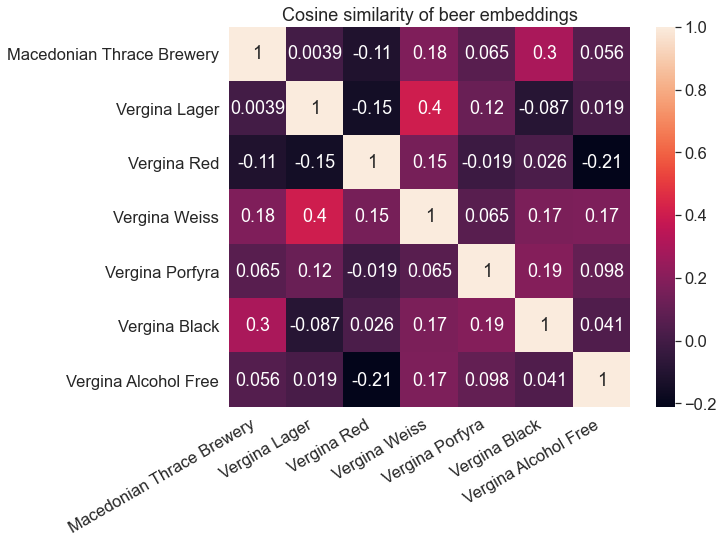

In [17]:
# beer_vecs = model.wv['Q12877510', 'Q93552342', 'Q93557205', 'Q93559285', 'Q93558270', 'Q93560567', 'Q97412285']
# similarity_mat = [model.wv.cosine_similarities(beer, beer_vecs) for beer in beer_vecs]
# mask = np.zeros_like(similarity_mat)
# mask[np.triu_indices_from(mask)] = True
# labels = ['Macedonian Thrace Brewery', 'Vergina Lager', 'Vergina Red', 'Vergina Weiss', 'Vergina Porfyra', 'Vergina Black', 'Vergina Alcohol Free']
# # Could mask to only show the lower triangle, but I think this is actually easier to read without the mask
# fig, ax = plt.subplots(figsize=(9,7))
# sns.set(font_scale=1.5)
# sns.heatmap(similarity_mat, ax=ax, xticklabels=labels, yticklabels=labels, annot=True)
# plt.xticks(rotation=30, horizontalalignment='right')
# plt.title("Cosine similarity of beer embeddings")
# plt.show()